In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
import os
# import robin_stocks.robinhood as r
import pickle5 as pickle
import pandas as pd
# sns.set_style("white")
# sns.set_palette("bright")
sns.set(font_scale=1.5)
sns.set_style("white")

import sys
sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.models import SingleTaskVariationalGP as SingleTaskCopulaProcessModel
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP
from voltron.train_utils import LearnGPCV, TrainVolModel, TrainDataModel
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

Warning no robinhood utils.


## Options Helpers

In [2]:
def GetTrainingData(SPY, date, N):
    idx = SPY[SPY["Date"] == date].index.item()
    return SPY['Close'].iloc[(idx-N):idx]

def GetTrueValue(SPY, date, strike):
    close_px = SPY['Close'][SPY["Date"] == date].item()
    return np.maximum(close_px-strike, 0)

def GetTradingDays(SPY, start, stop):
    start_idx = SPY[SPY["Date"] == start].index.item()
    stop_idx = SPY[SPY["Date"] == stop].index.item()
    return stop_idx-start_idx

def FindLastTradingDays(SPY, dates):
    last_days = []
    for date in dates:
        last_days.append(np.max(np.where(SPY.Date < date)[0]))
        
    return np.array(SPY.Date[last_days])

## Data

In [3]:
SPY = pd.read_csv("./data/SPY_prices.csv")
SPY['Date'] = pd.to_datetime(SPY['Date'])

## Data Setup

In [4]:
ntrain = 252
options = pd.read_csv("./data/SPY_" + str(2014) + ".csv")
options.expiration = pd.to_datetime(options.expiration)
options.quotedate = pd.to_datetime(options.quotedate)
qday = options.quotedate.unique()[0]
options = options[(options.quotedate == qday) & (options.type=='call')]
edays = options.expiration.sort_values().unique()
testdays = (edays - qday)/np.timedelta64(1, "D")
edays = edays[(testdays > 100) & (testdays < 500)]
lastdays = FindLastTradingDays(SPY, edays)
ntests = np.array([GetTradingDays(SPY, qday, pd.Timestamp(ld)) 
                   for ld in lastdays])
fulltest = ntests[-1]


train_y = torch.FloatTensor(GetTrainingData(SPY, qday, ntrain).to_numpy())
test_y = torch.FloatTensor(GetTrainingData(SPY, 
                                           pd.Timestamp(lastdays[-1]),
                                           fulltest).to_numpy())
full_x = torch.arange(ntrain+fulltest).type(torch.FloatTensor)
full_x = full_x/252.
dt = full_x[1] - full_x[0]
train_x = full_x[:ntrain]
test_x = full_x[ntrain:]

In [5]:
## learn vol with GPCV ##
vol = LearnGPCV(train_x, train_y, train_iters=400)/(dt**0.5)

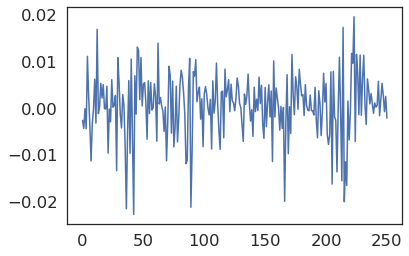

In [6]:
log_returns = torch.log(train_y[1:]/train_y[:-1])
plt.plot(log_returns)
plt.show()

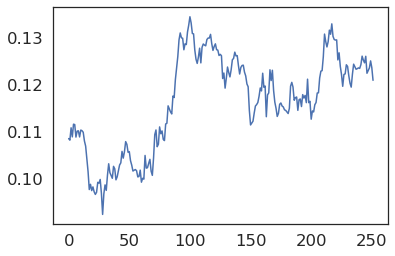

In [7]:
log_returns = torch.log(train_y[1:]/train_y[:-1])
plt.plot(vol)
plt.show()

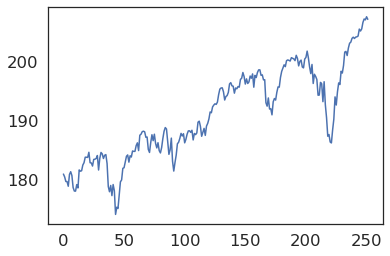

In [8]:
plt.plot(train_y)
plt.show()

In [9]:
## train vol GP ## 
vmod, vlh = TrainVolModel(train_x, vol, train_iters=500, printing=False)

## train data gp ##
dmod, dlh = TrainDataModel(train_x, train_y, vmod, vlh, vol, train_iters=500)

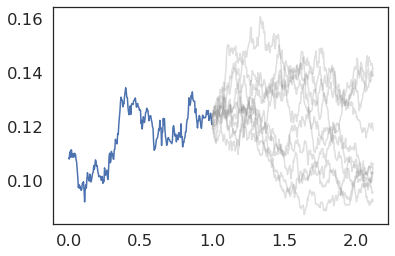

In [10]:
plt.plot(train_x, vol)
vmod.eval();
samples = vmod(test_x).sample(torch.Size((10,))).exp().detach()
plt.plot(test_x, samples.T, c='gray', alpha=0.25)
plt.show()

In [11]:
nvol = 100
npx = 100
px_samples = torch.zeros(npx*nvol, len(edays))
px_paths = torch.zeros(npx*nvol, fulltest)
vol_paths = torch.zeros(nvol, fulltest)
dmod.vol_model.eval();
dmod.eval();

for vidx in range(nvol):
#     print(vidx)
    vol_pred = dmod.vol_model(test_x).sample().exp()
    vol_paths[vidx, :] = vol_pred.detach()
    
    px_pred = dmod.GeneratePrediction(test_x, vol_pred, npx).exp()
    px_paths[vidx*npx:(vidx*npx + npx), :] = px_pred.detach().T
    px_samples[vidx*npx:(vidx*npx+npx), :] = px_pred[ntests-1].detach().T
    

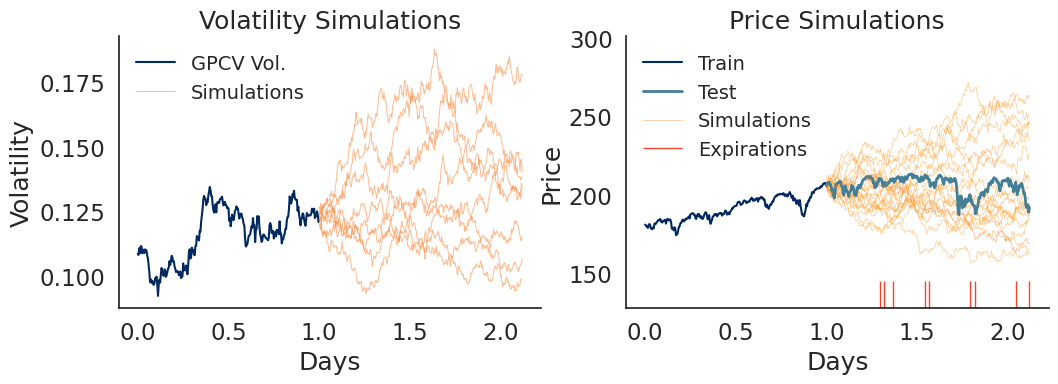

In [12]:
colors = ["#1b4079","#3db2ff","#ffedda","#ffb830","#ff2442","#61210f","#32373b"]
colors = ["#0c4767","#8A95A5", "#F4442E", "#566e3d","#b9a44c","#fa7921","#fe9920"]
colors = ["#01295F","#437F97", "#F4442E", "#566e3d","#b9a44c","#fa7921","#fe9920"]
fs = 16

fig, ax = plt.subplots(1,2, figsize=(12, 3.6), dpi=100)

ax[0].plot(train_x, vol, c=colors[0], label='GPCV Vol.')
vmod.eval();
samples = vmod(test_x).sample(torch.Size((20,))).exp().detach()
ax[0].plot(test_x, samples[0], c=colors[-2], alpha=0.5,
        lw=0.7, label="Simulations")
ax[0].plot(test_x, samples[1:8].T, c=colors[-2], alpha=0.5,
        lw=0.7)

ax[0].set_xlabel("Days")
ax[0].set_ylabel("Volatility")
ax[0].set_title("Volatility Simulations")
ax[0].legend(fontsize=fs-2, frameon=False)

ax[1].plot(train_x, train_y, c=colors[0], label="Train")

ax[1].plot(test_x, px_paths[1:20, :].T, c=colors[-1], alpha=0.5,
        lw=0.5)
# ax[1].plot(test_x, px_paths[0, :].T, c=colors[-1], alpha=0.5,
#         lw=0.2, label="Simulations")

ax[1].plot(test_x, test_y, c=colors[1], lw=2., label="Test")
ax[1].plot(test_x, px_paths[0, :].T, c=colors[-2], alpha=0.5,
        lw=0.5, label="Simulations")
sns.rugplot(x=test_x[ntests-1], ax=ax[1], color=colors[2], height=0.1, label="Expirations")
ax[1].legend(fontsize=fs-2, frameon=False)
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Price")
ax[1].set_title("Price Simulations")
plt.savefig("./option_diffusions.pdf", bbox_inches="tight")
sns.despine()
plt.show()

In [13]:
logger = []
days = np.datetime_as_string(edays, 'D')
for day in range(px_samples.shape[1]):
    for smpl in range(px_samples.shape[0]):
        logger.append([px_samples[smpl, day].item(), days[day][5:]])
        
df = pd.DataFrame(logger)
df.columns = ['Price', 'Date']

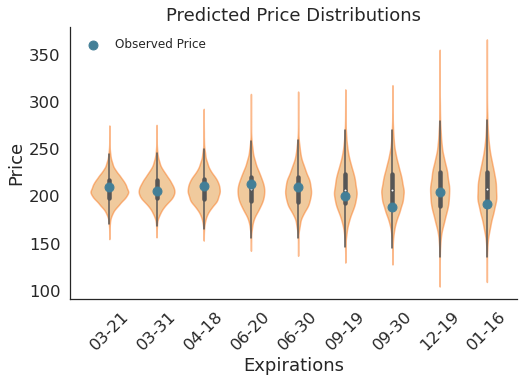

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
violins = sns.violinplot(x='Date', y='Price', data=df, color=colors[-1])
for violin in violins.collections[::2]:
    violin.set_alpha(0.5)
    violin.set_edgecolor(colors[-2])
#     violin.set_facecolor(colors[-2])

# parts = ax.violinplot(dataset=px_samples.T,positions=range(px_samples.shape[1]))
# for pc in parts['bodies']:
#     pc.set_facecolor(colors[2])
#     pc.set_edgecolor(colors[3])
#     pc.set_alpha(1)
plt.scatter(np.arange(px_samples.shape[1]), test_y[ntests-1], color=colors[1], zorder=4, s=80,
           label="Observed Price")
plt.xlabel("Expirations")
plt.xticks(rotation=45)
sns.despine()
plt.legend(loc="upper left",frameon=False, fontsize=fs-4)
plt.title("Predicted Price Distributions")
plt.savefig("./distribution_plot.pdf", bbox_inches='tight')
plt.show()

In [15]:
def Pricer(mc_pxs, options, edays, true_pxs):
    logger = []
    for eday_idx, eday in enumerate(edays):
        eday = pd.Timestamp(eday)
        opts = options[options.expiration==pd.Timestamp(eday)]
        for idx, row in opts.iterrows():
            K = row.strike
            bid = row.bid
            ask = row.ask
            valuation = np.mean(np.maximum(mc_pxs[:, eday_idx].numpy() - K, 0))
            rtn = np.maximum(true_pxs[eday_idx] - K, 0)
            logger.append([eday, K, bid, ask, valuation, rtn.item()])
            
    df = pd.DataFrame(logger)
    df.columns = ['Expiry', "Strike", "Bid", "Ask", "Voltron", "Return"]
    return df

In [16]:
option_output = Pricer(px_samples, options, edays, test_y[ntests-1])

In [17]:
idx = 3
print(edays[idx])
dat = option_output[option_output.Expiry == option_output.Expiry.unique()[idx]]

2015-06-20T00:00:00.000000000


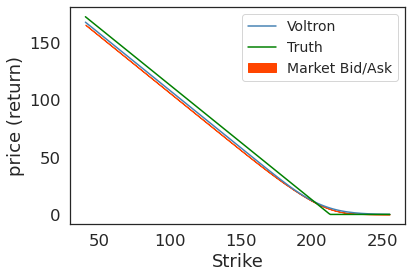

In [18]:
plt.plot(dat.Strike, dat.Voltron, c='steelblue', label="Voltron")
plt.plot(dat.Strike, dat.Return, c='green', label="Truth")
plt.fill_between(dat.Strike, dat.Bid, dat.Ask, color='OrangeRed',
                label="Market Bid/Ask")
plt.ylabel("price (return)")
plt.xlabel("Strike")
plt.legend(fontsize=14)
plt.show()

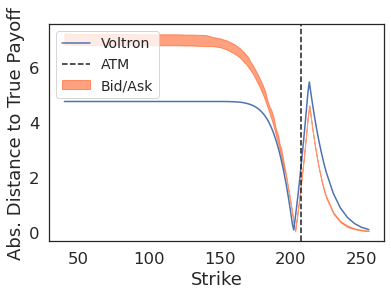

In [19]:
plt.plot(dat.Strike, np.abs(dat.Return-dat.Voltron), label="Voltron")
plt.fill_between(dat.Strike, np.abs(dat.Return-dat.Ask),
                 np.abs(dat.Return-dat.Bid),
                color="OrangeRed", alpha=0.5, label='Bid/Ask')
plt.ylabel("Abs. Distance to True Payoff", fontsize=18)
plt.xlabel("Strike")
plt.axvline(train_y[-1], label="ATM", c='k', ls='--')
plt.legend(fontsize=14)
plt.show()